In [11]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

sys.path.append(os.path.join(os.getcwd(), '../src'))
from metrics import calculate_topk_accuracy
import faissEncoder as faiss_enc
import utils

In [12]:
def barplot_top_accuracy(results, models, gaz_df, top_n, corpus, top_k_accuracy):
    """
    Plot the Top-K accuracy for each model and semantic tag.
    
    :param results: List of DataFrames with prediction results.
    :param models: List of model names.
    :param gaz_df: DataFrame containing the codes and semantic tags.
    :param top_n: Number of top semantic tags to consider.
    :param corpus: Title of the plot.
    """

    code_sem_tag_dict = gaz_df.set_index('code')['semantic_tag'].to_dict()
    test_df['sem_tag'] = test_df['code'].apply(lambda code: code_sem_tag_dict.get(code, "CODE_NOT_IN_DICT"))
    test_sem_tag_counts = test_df['sem_tag'].value_counts().to_dict()
    print(test_sem_tag_counts)
    top_tags = [k for k, v in sorted(test_sem_tag_counts.items(), key=lambda item: item[1], reverse=True)[:top_n]]

    for df in results:
        df['tag'] = df['code'].map(code_sem_tag_dict).fillna('others')
        df['tag'] = df['tag'].apply(lambda x: x if x in top_tags else 'others')

    results_dict = {}
    topk_values = [top_k_accuracy]
    for i, model in enumerate(models):
        df = results[i]
        for tag in top_tags + ['others']:  
            filtered_df = df[df['tag'] == tag]
            accuracy_dict = calculate_topk_accuracy(filtered_df, topk_values)
            accuracy = accuracy_dict[top_k_accuracy]
            if model not in results_dict:
                results_dict[model] = {}
            results_dict[model][tag] = accuracy

    data = []
    for model, tags in results_dict.items():
        for tag, accuracy in tags.items():
            data.append([model, tag, accuracy])

    results_df = pd.DataFrame(data, columns=['Model', 'Tag', 'Accuracy'])

    colors = ['red', 'blue', 'green', 'orange']

    plt.figure(figsize=(14, 4))
    ax = sns.barplot(x='Tag', y='Accuracy', hue='Model', data=results_df, palette=colors)

    for bar in ax.patches:
        height = bar.get_height()
        ax.add_patch(plt.Rectangle((bar.get_x(), height), bar.get_width(), 1 - height, 
                                   facecolor=bar.get_facecolor(), edgecolor='none', alpha=0.3))

    bars = ax.patches[:len(results_df['Model'].unique()) * len(results_df['Tag'].unique())]
    hatches = ['/////'] * len(bars)

    model_color_mapping = {model: colors[i] for i, model in enumerate(models)}

    for bar, hatch, model in zip(bars, hatches, results_df['Model']):
        bar.set_hatch(hatch)
        bar.set_edgecolor(model_color_mapping[model])
        bar.set_linewidth(0.8)
        bar.set_facecolor('white')

    handles, labels = ax.get_legend_handles_labels()
    for handle, model in zip(handles, models):
        handle.set_facecolor('white')
        handle.set_edgecolor(model_color_mapping[model])
        handle.set_hatch('/////')
    
    ax.legend(handles, models, title='Model', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, title_fontsize=16)

    ax.set_ylim(0, 1.05)

    ax.grid(False)

    ax.set_xlabel('')
    ax.set_ylabel('Percentage', fontsize=16)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.title(f'{corpus}', fontsize=14, fontweight='bold')
    plt.xticks(rotation=0, ha='center')
    plt.savefig(f'../pdf/{CORPUS}_bar_plot.pdf', bbox_inches='tight')                                                                                                                                                                               
    plt.show()

In [13]:
CORPUS = "MedProcNER"
models = []
results = []
F_TYPE = "FlatIP"
MAX_LENGTH = 256
TOP_N = 3
TOP_K_VALUES = [1,5,25,50,100,200]
mapped_semtag = {
    "estructura corporal": "body structure",
    "sustancia": "substance",
    "organismo": "organism",
    "anomalía morfológica": "morphologic abnormality",
    "hallazgo": "finding"
}

In [14]:
test_df, train_df, gaz_df = utils.load_corpus_data(CORPUS)
gaz_df['semantic_tag'] = gaz_df['semantic_tag'].replace(mapped_semtag)
link_gaz_df = pd.concat([train_df[['code', 'term']], gaz_df[['code', 'term']]], ignore_index=True) 
no_code_count = test_df['code'].str.contains('NO_CODE').sum()
composite_count = test_df['code'].str.contains(r'\+').sum()
print(f"Number of NO_CODE: {no_code_count}")
print(f"Number of composite(+): {composite_count}")
test_df = test_df[~test_df['code'].str.contains('NO_CODE|\+', regex=True)]

Number of NO_CODE: 17
Number of composite(+): 89


In [15]:
gaz_df.head()

,code,term,semantic_tag,mainterm,language
0,386219007,útero en el posparto: disminución del sangrado,procedure,0,es
1,83362003,última visita del médico al paciente internado...,procedure,0,es
2,733740006,úlcera isquémica ausente,situation,1,es
3,311745006,óxidos de plomo,substance,1,es
4,272156001,óxidos,substance,1,es


In [16]:
faiss_encoder = faiss_enc.FaissEncoder("../../../models/NEL/spanish_sapbert_models/sapbert_15_grandparents_1epoch", F_TYPE, MAX_LENGTH, link_gaz_df)
faiss_encoder.fitFaiss()
candidates, codes, _ = faiss_encoder.getCandidates(test_df["term"].tolist(), k=200)
clinlinker_granparent_preds = test_df.copy()
clinlinker_granparent_preds["candidates"] = candidates
clinlinker_granparent_preds["codes"] = codes
models.append("ClinLinker-KB-GP")
results.append(clinlinker_granparent_preds)
del faiss_encoder

Encoding:   0%|          | 0/7486 [00:00<?, ?it/s]

Encoding:   0%|          | 0/55 [00:00<?, ?it/s]

In [17]:
faiss_encoder = faiss_enc.FaissEncoder("../../../models/NEL/spanish_sapbert_models/sapbert_15_parents_1epoch", F_TYPE, MAX_LENGTH, link_gaz_df)
faiss_encoder.fitFaiss()
candidates, codes, _ = faiss_encoder.getCandidates(test_df["term"].tolist(), k=200)
clinlinker_parent_preds = test_df.copy()
clinlinker_parent_preds["candidates"] = candidates
clinlinker_parent_preds["codes"] = codes
models.append("ClinLinker-KB-P")
results.append(clinlinker_parent_preds)
del faiss_encoder

Encoding:   0%|          | 0/7486 [00:00<?, ?it/s]

Encoding:   0%|          | 0/55 [00:00<?, ?it/s]

In [18]:
faiss_encoder = faiss_enc.FaissEncoder("../../../models/NEL/spanish_sapbert_models/sapbert_15_noparents_1epoch", F_TYPE, MAX_LENGTH, link_gaz_df)
faiss_encoder.fitFaiss()
candidates, codes, _ = faiss_encoder.getCandidates(test_df["term"].tolist(), k=200)
clinlinker_preds = test_df.copy()
clinlinker_preds["candidates"] = candidates
clinlinker_preds["codes"] = codes
models.append("ClinLinker")
results.append(clinlinker_preds)
del faiss_encoder

Encoding:   0%|          | 0/7486 [00:00<?, ?it/s]

Encoding:   0%|          | 0/55 [00:00<?, ?it/s]

In [19]:
faiss_encoder = faiss_enc.FaissEncoder("cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR-large", F_TYPE, MAX_LENGTH, link_gaz_df)
faiss_encoder.fitFaiss()
candidates, codes, _ = faiss_encoder.getCandidates(test_df["term"].tolist(), k=200)
baseline_preds = test_df.copy()
baseline_preds["candidates"] = candidates
baseline_preds["codes"] = codes
models.append("SapBERT-XLM-R-large")
results.append(baseline_preds)
del faiss_encoder

/home/fernandogd/.conda/envs/kg_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Encoding:   0%|          | 0/7486 [00:00<?, ?it/s]

Encoding:   0%|          | 0/55 [00:00<?, ?it/s]

{'procedure': 3395, 'regime/therapy': 63, 'physical object': 14, 'product': 14, 'substance': 11, 'CODE_NOT_IN_DICT': 6, 'qualifier value': 6, 'finding': 2, 'context-dependent category': 1}


/tmp/ipykernel_32328/618121265.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)


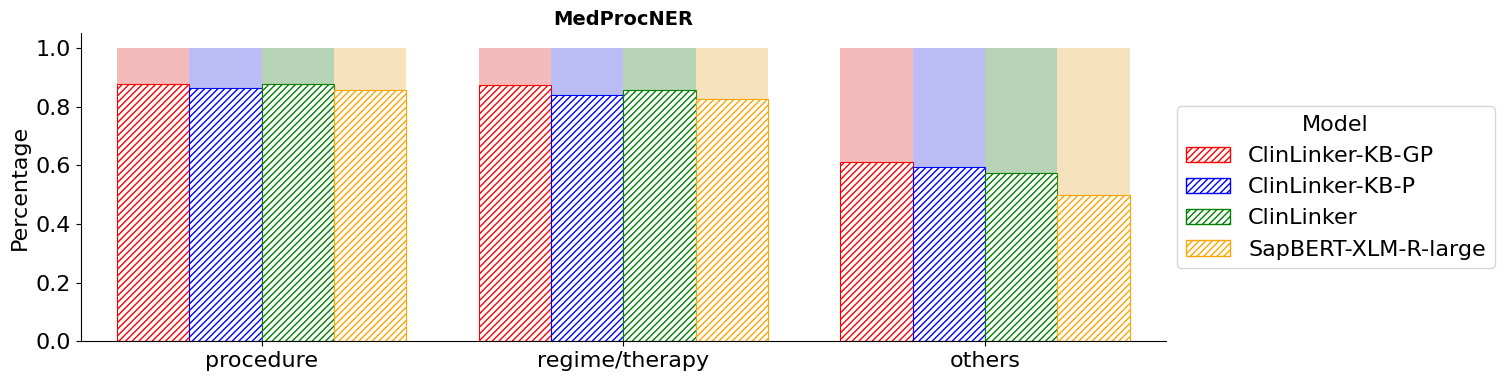

In [20]:
barplot_top_accuracy(results, models, gaz_df, 2, CORPUS, 25)